# Time series forecasting with ARIMA

In this notebook, we demonstrate how to:
- prepare time series data for training an ARIMA time series forecasting model
- implement a simple ARIMA model to forecast the next HORIZON steps ahead (time *t+1* through *t+HORIZON*) in the time series
- evaluate the model 


The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

## Install Dependencies
Get started by installing some of the required dependencies. These libraries with their corresponding versions are known to work for the solution:

* `statsmodels == 0.12.2`
* `matplotlib == 3.4.2`
* `scikit-learn == 0.24.2`


In [1]:
!pip install statsmodels

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 22.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 8.7 MB/s eta 0:00:00


In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

import sys
sys.path.append('..')
from common.utils import load_data, mape

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [17]:
energy = load_data('../data')[['load']]
energy

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
...                      ...
2014-12-31 19:00:00 4,012.00
2014-12-31 20:00:00 3,856.00
2014-12-31 21:00:00 3,671.00
2014-12-31 22:00:00 3,499.00
2014-12-31 23:00:00 3,345.00

[26304 rows x 1 columns]

Plot all available load data (January 2012 to Dec 2014)

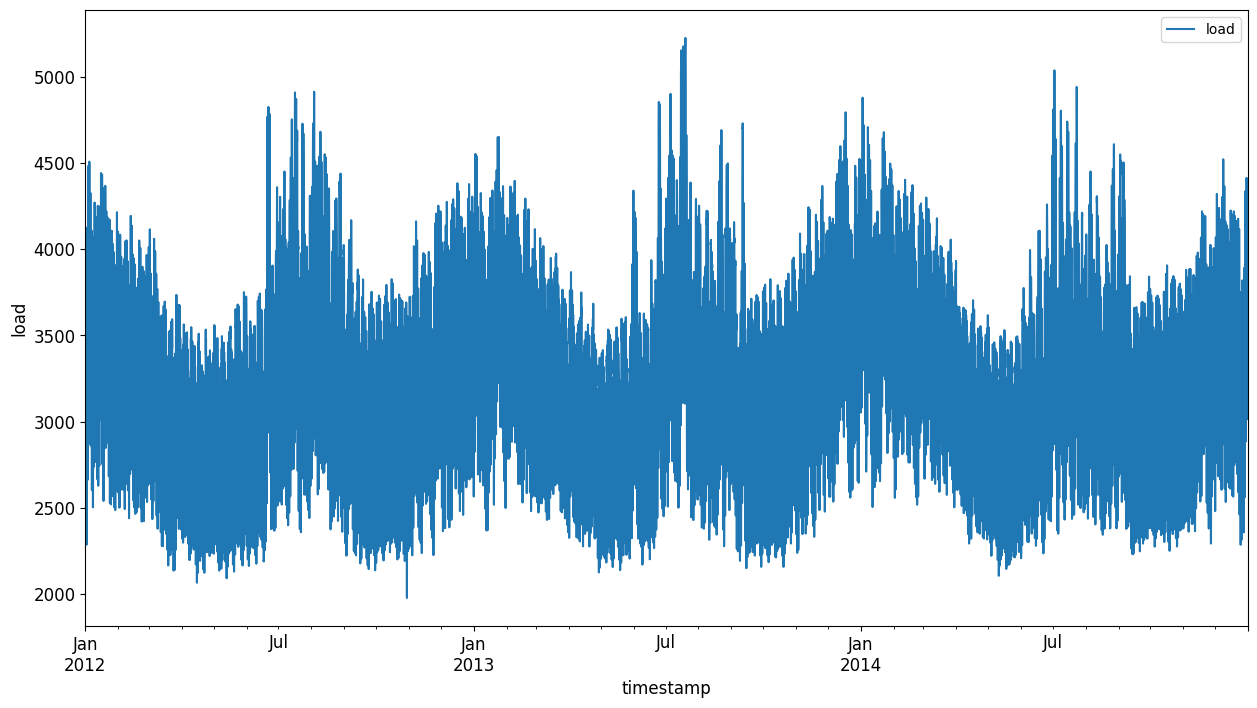

In [4]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Create training and testing data sets


In [5]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

In [6]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)]

load
2014-11-01 00:00:00 2,514.00
2014-11-01 01:00:00 2,434.00
2014-11-01 02:00:00 2,390.00
2014-11-01 03:00:00 2,382.00
2014-11-01 04:00:00 2,419.00
...                      ...
2014-12-29 19:00:00 4,183.00
2014-12-29 20:00:00 4,033.00
2014-12-29 21:00:00 3,778.00
2014-12-29 22:00:00 3,459.00
2014-12-29 23:00:00 3,203.00

[1416 rows x 1 columns]

In [7]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer')

train     test
2014-11-01 00:00:00 2,514.00      NaN
2014-11-01 01:00:00 2,434.00      NaN
2014-11-01 02:00:00 2,390.00      NaN
2014-11-01 03:00:00 2,382.00      NaN
2014-11-01 04:00:00 2,419.00      NaN
...                      ...      ...
2014-12-31 19:00:00      NaN 4,012.00
2014-12-31 20:00:00      NaN 3,856.00
2014-12-31 21:00:00      NaN 3,671.00
2014-12-31 22:00:00      NaN 3,499.00
2014-12-31 23:00:00      NaN 3,345.00

[1464 rows x 2 columns]

# 可视化差异

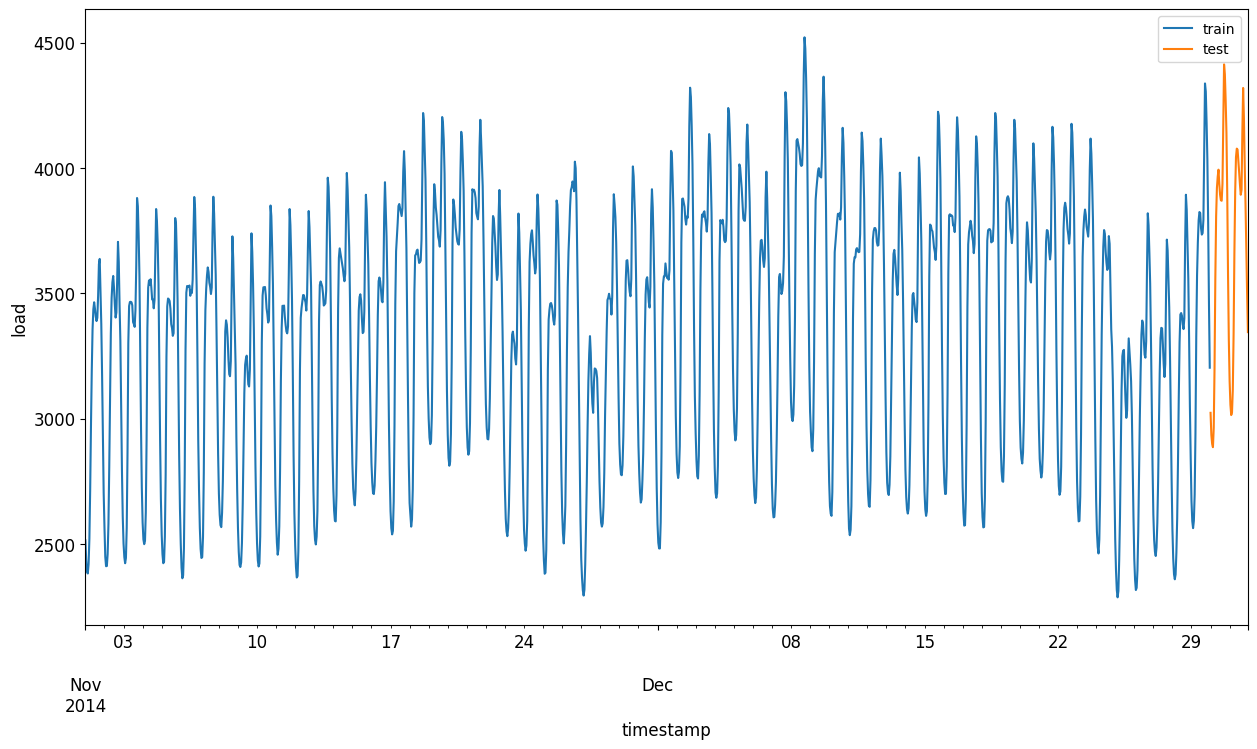

In [8]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [18]:
energy

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
...                      ...
2014-12-31 19:00:00 4,012.00
2014-12-31 20:00:00 3,856.00
2014-12-31 21:00:00 3,671.00
2014-12-31 22:00:00 3,499.00
2014-12-31 23:00:00 3,345.00

[26304 rows x 1 columns]

# Prepare the data for training

In [19]:
# 2014-11-01 -> 2014-12-30(一共约2个月)
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
# 2014-12-30 -> 2014-12-30(一共2天)
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [20]:
# 将数据缩放到 (0, 1) 范围内
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

load
2014-11-01 00:00:00  0.10
2014-11-01 01:00:00  0.07
2014-11-01 02:00:00  0.05
2014-11-01 03:00:00  0.04
2014-11-01 04:00:00  0.06
2014-11-01 05:00:00  0.10
2014-11-01 06:00:00  0.19
2014-11-01 07:00:00  0.31
2014-11-01 08:00:00  0.40
2014-11-01 09:00:00  0.48

Original vs scaled data:

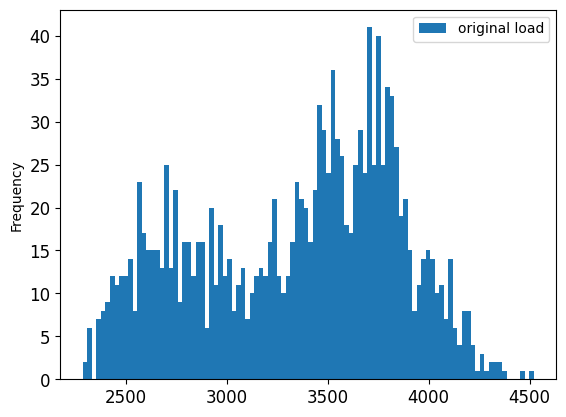

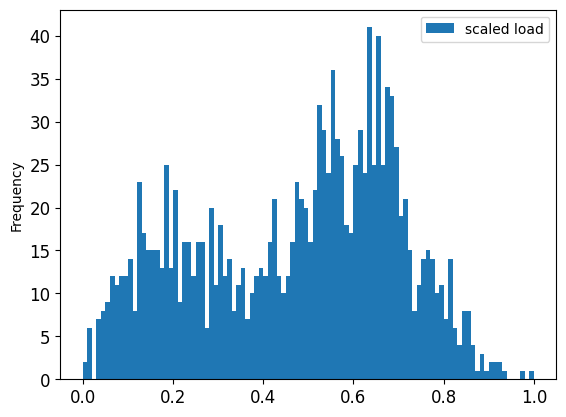

In [11]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

In [21]:
test.head()

load
2014-12-30 00:00:00 3,023.00
2014-12-30 01:00:00 2,935.00
2014-12-30 02:00:00 2,899.00
2014-12-30 03:00:00 2,886.00
2014-12-30 04:00:00 2,963.00

Let's also scale the test data

In [22]:
test['load'] = scaler.transform(test)
test.head()

load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30

## Implement ARIMA method

In [23]:
# Specify the number of steps to forecast ahead
# 为 ARIMA 模型参数选择最佳值可能具有挑战性，因为它有些主观且耗时。
# 您可以考虑使用 pyramid 库中的 auto_arima() 函数
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [24]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)
# 有 3 个参数用于帮助对时间序列的主要方面进行建模：季节性、趋势和噪声
# 如果您的数据具有季节性特征（本数据具有季节性特征），我们将使用季节性 ARIMA 模型 (SARIMA)
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
# Prepare the model for the training data
# 构建第一个模型
results = model.fit()

print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.45318D+00    |proj g|=  2.50788D+00


 This problem is unconstrained.



At iterate    5    f= -2.45393D+00    |proj g|=  5.28176D-01

At iterate   10    f= -2.45558D+00    |proj g|=  8.57193D-01

At iterate   15    f= -2.45565D+00    |proj g|=  1.32237D-02

At iterate   20    f= -2.45567D+00    |proj g|=  3.54529D-02

At iterate   25    f= -2.45567D+00    |proj g|=  8.82579D-02

At iterate   30    f= -2.45568D+00    |proj g|=  1.92055D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     54      1     0     0   1.198D-02  -2.456D+00
  F =  -2.4556784274003158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Result

## 输出解析

- 【注意】上面的输出被截断(或者下拉框)

### 最终优化结果：
- 在输出的最后部分，给出了优化的总迭代次数（Tit）、总函数评估次数（Tnf）、投影梯度的范数（Projg）以及最终的目标函数值（F）。
- 最终的目标函数值为 -2.4556784274003158。
```
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     54      1     0     0   1.198D-02  -2.456D+00
  F =  -2.4556784274003158     
```
### SARIMAX 模型结果

- 包括模型的系数、标准误差、z 值和 P 值等。
- 在这个例子中，SARIMAX 模型的阶数为 (4, 1, 0) x (1, 1, 0, 24)。

```
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.241
Date:                            Wed, 27 Dec 2023   AIC                          -6942.481
Time:                                    14:37:20   BIC                          -6911.055
Sample:                                11-01-2014   HQIC                         -6930.730
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8401      0.016     52.120      0.000       0.809       0.872
ar.L2         -0.5224      0.034    -15.380      0.000      -0.589      -0.456
ar.L3          0.1532      0.044      3.462      0.001       0.066       0.240
ar.L4         -0.0783      0.036     -2.172      0.030      -0.149      -0.008
ar.S.L24      -0.2340      0.024     -9.782      0.000      -0.281      -0.187
sigma2         0.0004   8.32e-06     47.350      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1461.74
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.14
Prob(H) (two-sided):                  0.07   Kurtosis:                         8.01
===================================================================================
```


## Evaluate the model

- 要评估您的模型，您可以执行所谓的 walk forward 验证。在实践中，每次有新数据可用时，时间序列模型都会重新训练。这使得模型能够在每个时间步做出最佳预测。

Create a test data point for each HORIZON step.

In [25]:
# 为每个 HORIZON 步骤创建一个测试数据点
test_shifted = test.copy()

# 数据根据其水平点水平移动
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')

test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

Make predictions on the test data

In [27]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

CPU times: user 278 µs, sys: 118 µs, total: 396 µs
Wall time: 425 µs


In [38]:
print(list(test_ts.iloc[1]))
test_ts.head()

[0.2900626678603402, 0.2739480752014323, 0.26812891674127126]


load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

In [41]:
%%time
predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
#for t in range(3):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    # 调用 forecast() 函数并指定要预测的步骤数 (horizon) 进行预测
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42198D+00    |proj g|=  8.36871D-01

At iterate    5    f= -2.42207D+00    |proj g|=  4.13672D-01

At iterate   10    f= -2.42533D+00    |proj g|=  5.51838D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     41      1     0     0   5.314D-02  -2.425D+00
  F =  -2.4253292506206940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 00:00:00
1 : predicted = [0.28 0.32 0.42] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42035D+00    |proj g|=  1.11977D+00

At iterate    5    f= -2.42116D+00    |proj g|=  2.31902D+00

At iterate   10    f= -2.42428D+00    |proj g|=  1.34990D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     56      2     0     0   1.350D-02  -2.424D+00
  F =  -2.4242838115964753     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-30 01:00:00
2 : predicted = [0.41 0.51 0.66] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.39868D+00    |proj g|=  1.93314D+00


 This problem is unconstrained.



At iterate    5    f= -2.39909D+00    |proj g|=  5.00894D-01

At iterate   10    f= -2.40317D+00    |proj g|=  1.01677D+00

At iterate   15    f= -2.40332D+00    |proj g|=  1.38326D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     37      1     0     0   1.275D-01  -2.403D+00
  F =  -2.4033177903710010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 02:00:00
3 : predicted = [0.3  0.41 0.53] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           

 This problem is unconstrained.



At iterate    5    f= -2.42414D+00    |proj g|=  1.85361D+00

At iterate   10    f= -2.42569D+00    |proj g|=  7.50274D-03

At iterate   15    f= -2.42570D+00    |proj g|=  1.94676D-01

At iterate   20    f= -2.42574D+00    |proj g|=  2.37877D-02

At iterate   25    f= -2.42574D+00    |proj g|=  3.87774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     34      1     0     0   3.878D-04  -2.426D+00
  F =  -2.4257437648372497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 03:00:00
4 : predicted = [0.37 0.48 0.58] expected = [0.26812891674127126, 0.3025962399283795, 0.40823

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41210D+00    |proj g|=  1.66512D+00

At iterate    5    f= -2.41316D+00    |proj g|=  1.54403D+00

At iterate   10    f= -2.41406D+00    |proj g|=  9.63387D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     44      1     0     0   8.925D-03  -2.414D+00
  F =  -2.4140649889191939     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 04:00:00
5 : predicted = [0.29 0.37 0.46] expected = [0.302


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41526D+00    |proj g|=  2.00399D+00

At iterate    5    f= -2.41574D+00    |proj g|=  6.79860D-01

At iterate   10    f= -2.41710D+00    |proj g|=  5.24337D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     26      1     0     0   6.101D-03  -2.417D+00
  F =  -2.4171020217058685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 05:00:00
6 : predicted = [0.38 0.47 0.53] expected = [0.408

 This problem is unconstrained.



At iterate    5    f= -2.42655D+00    |proj g|=  2.45217D-01

At iterate   10    f= -2.42705D+00    |proj g|=  1.32690D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     24      1     0     0   7.867D-03  -2.427D+00
  F =  -2.4273584835778688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 06:00:00
7 : predicted = [0.52 0.58 0.59] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42267D+00    |proj g|=  2.82837D+00

At iterate    5    f= -2.42354D+00    |proj g|=  7.57161D-02

At iterate   10    f= -2.42379D+00    |proj g|=  9.89327D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     38      1     0     0   2.494D-02  -2.424D+00
  F =  -2.4239683758771147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 07:00:00
8 : predicted = [0.67 0.68 0.64] expected = [0.6799462846911368, 0.7309758281110115, 0.7511190689346463]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42285D+00    |proj g|=  2.86723D+00


 This problem is unconstrained.



At iterate    5    f= -2.42375D+00    |proj g|=  9.26186D-02

At iterate   10    f= -2.42404D+00    |proj g|=  5.80179D-02

At iterate   15    f= -2.42405D+00    |proj g|=  1.86750D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f= -2.42406D+00    |proj g|=  5.53238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     65      1     0     0   5.532D-03  -2.424D+00
  F =  -2.4240594695253188     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 08:00:00
9 : predicted = [0.7  0.66 0.62] expected = [0.7309758281110115, 0.7511190689346463, 0.7636526410026856]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.42194D+00    |proj g|=  2.85439D+00


 This problem is unconstrained.



At iterate    5    f= -2.42283D+00    |proj g|=  7.27315D-02

At iterate   10    f= -2.42296D+00    |proj g|=  4.78350D-01

At iterate   15    f= -2.42313D+00    |proj g|=  5.40977D-02

At iterate   20    f= -2.42314D+00    |proj g|=  5.27062D-02
  ys=-2.378E-09  -gs= 1.354E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     86      2     1     0   5.743D-03  -2.423D+00
  F =  -2.4231357376373386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 09:00:00
10 : predicted = [0.71 0.68 0.66] expected = [0.7511190689346463, 0.7636526410026856, 0.7381378692927483]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41973D+00    |proj g|=  2.94100D+00


 This problem is unconstrained.



At iterate    5    f= -2.42069D+00    |proj g|=  1.66776D-01

At iterate   10    f= -2.42107D+00    |proj g|=  2.42041D-01

At iterate   15    f= -2.42108D+00    |proj g|=  6.73137D-02
  ys=-2.239E-13  -gs= 8.430E-12 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     55      1     1     0   1.592D-02  -2.421D+00
  F =  -2.4210786730602010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-30 10:00:00
11 : predicted = [0.75 0.74 0.75] expected = [0.7636526410026856, 0.7381378692927483, 0.7188898836168307]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.41997D+00    |proj g|=  2.94802D+00


 This problem is unconstrained.



At iterate    5    f= -2.42093D+00    |proj g|=  5.13702D-02

At iterate   10    f= -2.42126D+00    |proj g|=  3.40588D-01
  ys=-2.345E-07  -gs= 1.260E-07 BFGS update SKIPPED

At iterate   15    f= -2.42127D+00    |proj g|=  3.88285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     33      1     1     0   3.883D-03  -2.421D+00
  F =  -2.4212746929139599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 11:00:00
12 : predicted = [0.77 0.78 0.9 ] expected = [0.7381378692927483, 0.7188898836168307, 0.7090420769919425]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f= -2.41964D+00    |proj g|=  1.20930D-01

At iterate   10    f= -2.42004D+00    |proj g|=  5.83181D-03

At iterate   15    f= -2.42005D+00    |proj g|=  1.98258D-02

At iterate   20    f= -2.42005D+00    |proj g|=  3.45730D-03
  ys=-4.171E-07  -gs= 2.112E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     40      1     1     0   5.948D-03  -2.420D+00
  F =  -2.4200523264917391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 12:00:00
13 : predicted = [0.73 0.84 0.95] expected = [0.7188898836168307, 0.7090420769919425, 0.708146821844225

 This problem is unconstrained.



At iterate    5    f= -2.42134D+00    |proj g|=  1.08640D-01

At iterate   10    f= -2.42165D+00    |proj g|=  2.59053D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     22      1     0     0   2.597D-02  -2.422D+00
  F =  -2.4216534017855484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 13:00:00
14 : predicted = [0.82 0.93 0.92] expected = [0.7090420769919425, 0.7081468218442255, 0.7385854968666068]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At it

 This problem is unconstrained.



At iterate    5    f= -2.40043D+00    |proj g|=  5.25197D-02

At iterate   10    f= -2.40069D+00    |proj g|=  1.28422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     20      1     0     0   1.124D-02  -2.401D+00
  F =  -2.4006891284183989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 14:00:00
15 : predicted = [0.72 0.68 0.65] expected = [0.7081468218442255, 0.7385854968666068, 0.8478066248880931]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At it

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      9      1     0     0   1.192D-02  -2.401D+00
  F =  -2.4009842077465802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 15:00:00
16 : predicted = [0.66 0.62 0.59] expected = [0.7385854968666068, 0.8478066248880931, 0.9516562220232765]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.38922D+00    |proj g|=  2.74674D+00


 This problem is unconstrained.



At iterate    5    f= -2.39010D+00    |proj g|=  1.17992D-01

At iterate   10    f= -2.39039D+00    |proj g|=  4.92564D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     32      1     0     0   4.926D-03  -2.390D+00
  F =  -2.3903949602973507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 16:00:00
17 : predicted = [0.78 0.77 0.67] expected = [0.8478066248880931, 0.9516562220232765, 0.934198746642793]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.38182D+00    |proj g|=  2.69233D+00


 This problem is unconstrained.



At iterate    5    f= -2.38268D+00    |proj g|=  2.07643D-01

At iterate   10    f= -2.38298D+00    |proj g|=  1.42560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     22      1     0     0   3.902D-03  -2.383D+00
  F =  -2.3829793996786806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 17:00:00
18 : predicted = [0.9  0.82 0.64] expected = [0.9516562220232765, 0.934198746642793, 0.8876454789615038]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At ite

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     43      2     0     0   2.617D-02  -2.379D+00
  F =  -2.3794141727444020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 18:00:00
19 : predicted = [0.91 0.75 0.59] expected = [0.934198746642793, 0.8876454789615038, 0.8294538943598924]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.37771D+00    |proj g|=  2.68542D+00


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      8      1     0     0   1.929D-02  -2.379D+00
  F =  -2.3785703433094705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 19:00:00
20 : predicted = [0.8  0.64 0.52] expected = [0.8876454789615038, 0.8294538943598924, 0.7197851387645477]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.36477D+00    |proj g|=  2.63536D+00


 This problem is unconstrained.



At iterate    5    f= -2.36562D+00    |proj g|=  3.54325D-02

At iterate   10    f= -2.36583D+00    |proj g|=  1.37319D-01

At iterate   15    f= -2.36584D+00    |proj g|=  1.11959D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     42      1     0     0   1.120D-01  -2.366D+00
  F =  -2.3658448086850319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 20:00:00
21 : predicted = [0.82 0.73 0.66] expected = [0.8294538943598924, 0.7197851387645477, 0.5747538048343777]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.36450D+00    |proj g|=  2.64026D+00


 This problem is unconstrained.



At iterate    5    f= -2.36536D+00    |proj g|=  4.00346D-02

At iterate   10    f= -2.36555D+00    |proj g|=  2.79327D-01

At iterate   15    f= -2.36556D+00    |proj g|=  4.68794D-03
  ys=-6.072E-09  -gs= 1.323E-08 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     51      1     1     0   4.580D-03  -2.366D+00
  F =  -2.3655607099340128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 21:00:00
22 : predicted = [0.75 0.69 0.65] expected = [0.7197851387645477, 0.5747538048343777, 0.4592658907788718]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.36293D+00    |proj g|=  2.64407D+00


 This problem is unconstrained.



At iterate    5    f= -2.36379D+00    |proj g|=  2.67267D-02

At iterate   10    f= -2.36399D+00    |proj g|=  4.30555D-03

At iterate   15    f= -2.36401D+00    |proj g|=  2.01150D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     36      1     0     0   2.012D-02  -2.364D+00
  F =  -2.3640050210322077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 22:00:00
23 : predicted = [0.63 0.58 0.62] expected = [0.5747538048343777, 0.4592658907788718, 0.3858549686660697]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      7      1     0     0   1.194D-02  -2.359D+00
  F =  -2.3593923926766913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-30 23:00:00
24 : predicted = [0.48 0.5  0.5 ] expected = [0.4592658907788718, 0.3858549686660697, 0.34377797672336596]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.35852D+00    |proj g|=  2.53567D+00


 This problem is unconstrained.



At iterate    5    f= -2.35931D+00    |proj g|=  6.17392D-02

At iterate   10    f= -2.35941D+00    |proj g|=  2.13142D-01

At iterate   15    f= -2.35949D+00    |proj g|=  2.17478D-02

At iterate   20    f= -2.35950D+00    |proj g|=  2.56079D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   3.092D-03  -2.359D+00
  F =  -2.3594989057168951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 00:00:00
25 : predicted = [0.46 0.46 0.51] expected = [0.3858549686660697, 0.34377797672336596, 0.32542524619516544]
RUNNING THE L-BFGS-B CODE

           * * *

Ma

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3      7      1     0     0   1.069D-02  -2.350D+00
  F =  -2.3500983358468654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 01:00:00
26 : predicted = [0.31 0.32 0.39] expected = [0.34377797672336596, 0.32542524619516544, 0.33034914950760963]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34689D+00    |proj g|=  3.05345D+00


 This problem is unconstrained.



At iterate    5    f= -2.34811D+00    |proj g|=  1.23722D-01

At iterate   10    f= -2.34850D+00    |proj g|=  1.06977D+00

At iterate   15    f= -2.34871D+00    |proj g|=  5.13426D-03

At iterate   20    f= -2.34871D+00    |proj g|=  1.89108D-02

At iterate   25    f= -2.34873D+00    |proj g|=  2.98494D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     57      1     0     0   2.732D-02  -2.349D+00
  F =  -2.3487329601703055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 02:00:00
27 : predicted = [0.4  0.48 0.57] expected = [0.32542524619516544, 0.33034914950760963, 0.370

 This problem is unconstrained.



At iterate    5    f= -2.34070D+00    |proj g|=  1.04557D-01

At iterate   10    f= -2.34117D+00    |proj g|=  1.06651D+00

At iterate   15    f= -2.34134D+00    |proj g|=  2.84638D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   2.846D-02  -2.341D+00
  F =  -2.3413445554853047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 03:00:00
28 : predicted = [0.35 0.4  0.5 ] expected = [0.33034914950760963, 0.3706356311548791, 0.470008952551477]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           

 This problem is unconstrained.



At iterate    5    f= -2.34012D+00    |proj g|=  1.20006D-01

At iterate   10    f= -2.34091D+00    |proj g|=  3.00149D-01

At iterate   15    f= -2.34095D+00    |proj g|=  1.07197D-02

At iterate   20    f= -2.34095D+00    |proj g|=  7.67637D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f= -2.34095D+00    |proj g|=  4.41610D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     60      1     0     0   4.416D-03  -2.341D+00
  F =  -2.3409540057103415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 04:00:00
29 : predicted = [0.37 0.46 0.6 ] expected = [0.3706356311548791, 0.470008952551477, 0.6145926589077886]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33929D+00    |proj g|=  2.71185D+00


 This problem is unconstrained.



At iterate    5    f= -2.34025D+00    |proj g|=  9.74198D-02

At iterate   10    f= -2.34110D+00    |proj g|=  2.78658D-02

At iterate   15    f= -2.34112D+00    |proj g|=  6.01110D-02

At iterate   20    f= -2.34112D+00    |proj g|=  1.59337D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     81      2     0     0   4.345D-03  -2.341D+00
  F =  -2.3411181397397987     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 05:00:00
30 : predicted = [0.47 0.61 0.7 ] expected = [0.470008952551477, 0.6145926589077886, 0.7247090420769919]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33969D+00    |proj g|=  2.72062D+00


 This problem is unconstrained.



At iterate    5    f= -2.34066D+00    |proj g|=  1.11914D-01

At iterate   10    f= -2.34101D+00    |proj g|=  1.50254D+00

At iterate   15    f= -2.34152D+00    |proj g|=  6.04856D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   6.041D-02  -2.342D+00
  F =  -2.3415205297351473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 06:00:00
31 : predicted = [0.61 0.7  0.74] expected = [0.6145926589077886, 0.7247090420769919, 0.786034019695613]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           1

 This problem is unconstrained.



At iterate    5    f= -2.34144D+00    |proj g|=  7.30577D-02

At iterate   10    f= -2.34163D+00    |proj g|=  4.99650D-01

At iterate   15    f= -2.34242D+00    |proj g|=  9.06651D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   5.088D-03  -2.342D+00
  F =  -2.3424192050203696     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 07:00:00
32 : predicted = [0.71 0.75 0.76] expected = [0.7247090420769919, 0.786034019695613, 0.8012533572068039]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           1

 This problem is unconstrained.



At iterate    5    f= -2.34104D+00    |proj g|=  1.31814D-01

At iterate   10    f= -2.34138D+00    |proj g|=  5.79938D-01

At iterate   15    f= -2.34217D+00    |proj g|=  2.11768D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     45      1     0     0   2.990D-02  -2.342D+00
  F =  -2.3421701335511362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 08:00:00
33 : predicted = [0.78 0.79 0.79] expected = [0.786034019695613, 0.8012533572068039, 0.7994628469113696]


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33991D+00    |proj g|=  2.73974D+00

At iterate    5    f= -2.34089D+00    |proj g|=  1.08735D-01

At iterate   10    f= -2.34173D+00    |proj g|=  1.30167D+00

At iterate   15    f= -2.34208D+00    |proj g|=  4.81638D-02

At iterate   20    f= -2.34209D+00    |proj g|=  2.99271D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   2.538D-02  -2.342D+00
  F =  -2.3420888653011827     

CONVERG

 This problem is unconstrained.



At iterate    5    f= -2.34115D+00    |proj g|=  1.39553D-01

At iterate   10    f= -2.34180D+00    |proj g|=  3.48330D-01

At iterate   15    f= -2.34237D+00    |proj g|=  4.06440D-03
  ys=-2.746E-07  -gs= 9.995E-08 BFGS update SKIPPED
  ys=-3.351E-10  -gs= 1.709E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     97      3     2     0   5.920D-03  -2.342D+00
  F =  -2.3423665198478174     

ABNORMAL_TERMINATION_IN_LNSRCH                              
2014-12-31 10:00:00
35 : predicted = [0.8  0.78 0.76] expected = [0.7994628469113696, 0.780214861235452, 0.7587287376902416]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34044D+00    |proj g|=  2.75448D+00


 This problem is unconstrained.



At iterate    5    f= -2.34143D+00    |proj g|=  9.43584D-02

At iterate   10    f= -2.34266D+00    |proj g|=  2.14792D-01

At iterate   15    f= -2.34267D+00    |proj g|=  9.52731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     37      1     0     0   1.222D-02  -2.343D+00
  F =  -2.3426670180681173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 11:00:00
36 : predicted = [0.77 0.76 0.78] expected = [0.780214861235452, 0.7587287376902416, 0.7367949865711727]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           1

 This problem is unconstrained.



At iterate    5    f= -2.34123D+00    |proj g|=  1.87868D-01

At iterate   10    f= -2.34249D+00    |proj g|=  2.60619D-01

At iterate   15    f= -2.34254D+00    |proj g|=  7.92189D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.34255D+00    |proj g|=  2.55228D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f= -2.34255D+00    |proj g|=  2.19949D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26    121      4     0     0   2.199D-02  -2.343D+00
  F =  -2.3425530917917503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


2014-12-31 12:00:00
37 : predicted = [0.78 0.8  0.84] expected = [0.7587287376902416, 0.7367949865711727, 0.7188898836168307]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34046D+00    |proj g|=  2.72704D+00


 This problem is unconstrained.



At iterate    5    f= -2.34144D+00    |proj g|=  1.54916D-01

At iterate   10    f= -2.34201D+00    |proj g|=  1.59050D+00

At iterate   15    f= -2.34274D+00    |proj g|=  1.04847D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     37      1     0     0   1.048D-02  -2.343D+00
  F =  -2.3427378790637405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 13:00:00
38 : predicted = [0.77 0.8  0.82] expected = [0.7367949865711727, 0.7188898836168307, 0.7273948075201431]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33929D+00    |proj g|=  2.61903D+00


 This problem is unconstrained.



At iterate    5    f= -2.34018D+00    |proj g|=  1.75473D-01

At iterate   10    f= -2.34131D+00    |proj g|=  5.66838D-01

At iterate   15    f= -2.34136D+00    |proj g|=  4.70521D-03

At iterate   20    f= -2.34139D+00    |proj g|=  1.25671D-02

At iterate   25    f= -2.34140D+00    |proj g|=  7.85244D-02
  ys=-1.121E-08  -gs= 5.660E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     66      1     1     0   2.960D-02  -2.341D+00
  F =  -2.3413963721339539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 14:00:00
39 : predicted = [0.73 0.74 0.81] expecte

 This problem is unconstrained.



At iterate    5    f= -2.33990D+00    |proj g|=  2.89097D-01

At iterate   10    f= -2.34137D+00    |proj g|=  3.90502D-01

At iterate   15    f= -2.34141D+00    |proj g|=  1.61745D-02

At iterate   20    f= -2.34145D+00    |proj g|=  2.38444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     41      1     0     0   2.404D-03  -2.341D+00
  F =  -2.3414477828376077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 15:00:00
40 : predicted = [0.72 0.79 0.86] expected = [0.7273948075201431, 0.8299015219337511, 0.909579230080573]
RUNNING THE L-BFGS-B CODE

           * * *

Machi

 This problem is unconstrained.



At iterate    5    f= -2.33988D+00    |proj g|=  2.89712D-01

At iterate   10    f= -2.34088D+00    |proj g|=  1.60020D+00

At iterate   15    f= -2.34124D+00    |proj g|=  1.86358D-02
  ys=-1.752E-08  -gs= 2.313E-08 BFGS update SKIPPED

At iterate   20    f= -2.34125D+00    |proj g|=  9.29242D-02

At iterate   25    f= -2.34126D+00    |proj g|=  1.54919D-01

At iterate   30    f= -2.34126D+00    |proj g|=  7.13332D-02

At iterate   35    f= -2.34127D+00    |proj g|=  2.76976D-02
  ys=-1.662E-08  -gs= 3.663E-08 BFGS update SKIPPED

At iterate   40    f= -2.34127D+00    |proj g|=  3.62822D-03
  ys=-3.903E-10  -gs= 1.011E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41    108      2     3     0   1.577D-03  -2.341D+00
  F =  -2.3412713686668174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 16:00:00
41 : predicted = [0.81 0.89 0.85] expected = [0.8299015219337511, 0.909579230080573, 0.855863921217547]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33848D+00    |proj g|=  2.47530D+00


 This problem is unconstrained.



At iterate    5    f= -2.33930D+00    |proj g|=  3.79778D-01

At iterate   10    f= -2.34081D+00    |proj g|=  2.45849D-02

At iterate   15    f= -2.34082D+00    |proj g|=  3.08809D-02

At iterate   20    f= -2.34083D+00    |proj g|=  3.85825D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     76      2     0     0   9.340D-03  -2.341D+00
  F =  -2.3408319170927334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 17:00:00
42 : predicted = [0.93 0.9  0.83] expected = [0.909579230080573, 0.855863921217547, 0.7721575649059982]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.33782D+00    |proj g|=  2.49984D+00


 This problem is unconstrained.



At iterate    5    f= -2.33873D+00    |proj g|=  5.73578D-01

At iterate   10    f= -2.34038D+00    |proj g|=  7.29927D-02

At iterate   15    f= -2.34038D+00    |proj g|=  1.31327D-01

At iterate   20    f= -2.34040D+00    |proj g|=  1.15820D-01

At iterate   25    f= -2.34041D+00    |proj g|=  7.63092D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     52      1     0     0   3.802D-02  -2.340D+00
  F =  -2.3404066184312295     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 18:00:00
43 : predicted = [0.87 0.79 0.71] expected = [0.855863921217547, 0.7721575649059982, 0.702327

 This problem is unconstrained.



At iterate    5    f= -2.33888D+00    |proj g|=  4.18856D-01

At iterate   10    f= -2.34045D+00    |proj g|=  1.78356D-01

At iterate   15    f= -2.34049D+00    |proj g|=  3.70545D-03

At iterate   20    f= -2.34051D+00    |proj g|=  2.18233D-02

At iterate   25    f= -2.34051D+00    |proj g|=  1.70392D-02
  ys=-2.579E-08  -gs= 5.970E-08 BFGS update SKIPPED

At iterate   30    f= -2.34051D+00    |proj g|=  1.49023D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     57      1     1     0   1.490D-03  -2.341D+00
  F =  -2.3405123141134196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate    5    f= -2.33938D+00    |proj g|=  2.90977D-01

At iterate   10    f= -2.34066D+00    |proj g|=  2.08047D-01

At iterate   15    f= -2.34082D+00    |proj g|=  7.00420D-03

At iterate   20    f= -2.34082D+00    |proj g|=  1.87895D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     42      1     0     0   1.879D-02  -2.341D+00
  F =  -2.3408167043033923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 20:00:00
45 : predicted = [0.69 0.59 0.48] expected = [0.7023276633840643, 0.6195165622202325, 0.5425246195165621]
RUNNING THE L-BFGS-B CODE

           * * *

Mach

 This problem is unconstrained.



At iterate    5    f= -2.33941D+00    |proj g|=  5.63861D-01

At iterate   10    f= -2.34074D+00    |proj g|=  1.12307D-01

At iterate   15    f= -2.34074D+00    |proj g|=  3.07036D-02

At iterate   20    f= -2.34077D+00    |proj g|=  6.24323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     38      1     0     0   1.022D-02  -2.341D+00
  F =  -2.3407710742612284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2014-12-31 21:00:00
46 : predicted = [0.61 0.5  0.41] expected = [0.6195165622202325, 0.5425246195165621, 0.4735899731423454]
CPU times: user 9min 36s, sys: 5min 29s, total: 1

Compare predictions to actual load

### 输出说明

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]

2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]

2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]

- 可以看到每个时间点预测结果和期望结果的对比



#### 问题描述：

输出一开始指出这是一个无约束问题（This problem is unconstrained）。







In [42]:
# 将预测与实际负载进行比较
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction   actual
0 2014-12-30 00:00:00  t+1    2,917.90 3,023.00
1 2014-12-30 01:00:00  t+1    3,199.22 2,935.00
2 2014-12-30 02:00:00  t+1    2,947.38 2,899.00
3 2014-12-30 03:00:00  t+1    3,106.59 2,886.00
4 2014-12-30 04:00:00  t+1    2,945.76 2,963.00

### Check model accuracy
Compute the **mean absolute percentage error (MAPE)** over all predictions

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$

In [43]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.02
t+2   0.05
t+3   0.08
Name: APE, dtype: float64


In [45]:
# Calculate one step's MAPE:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  1.984902889125182 %


In [46]:
# Print the multi-step forecast MAPE:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  4.791035167886451 %


Plot the predictions vs the actuals for the first week of the test set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


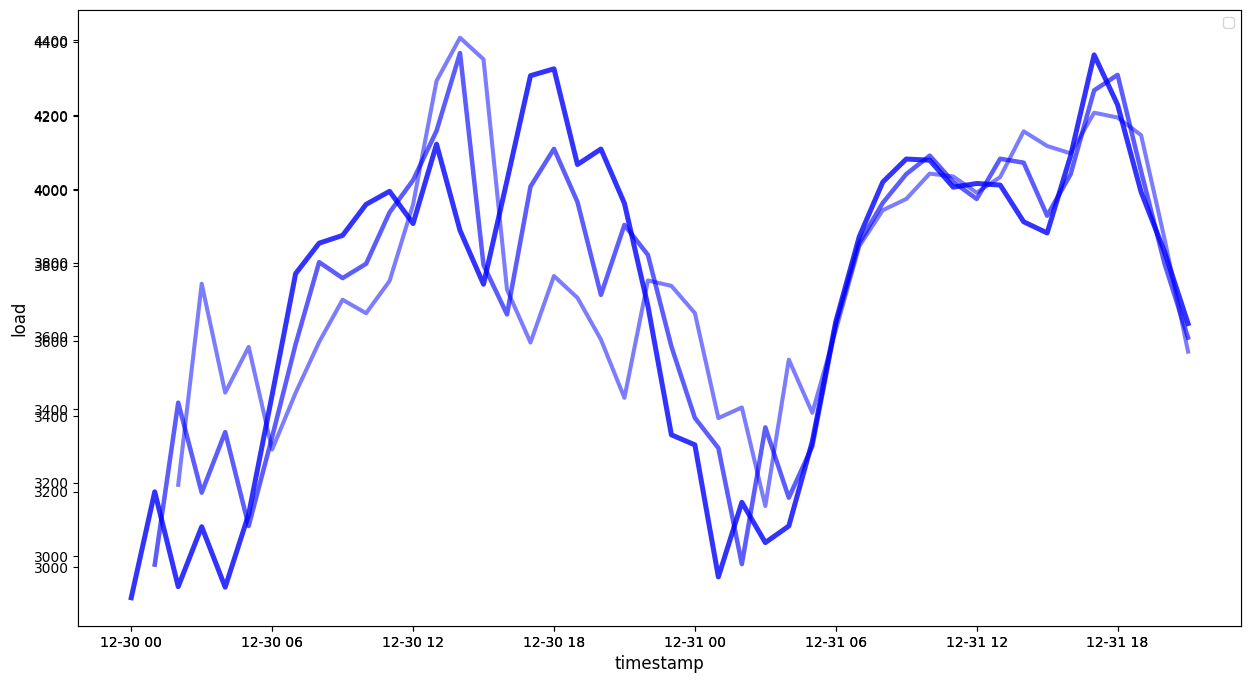

In [47]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()